## Plotting "Data Volume" and "Accumulated Data Volume" as monthly for "miseq01".

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import strftime, localtime
from sklearn.metrics import r2_score

Reading Parquet file from my local system (Before running, please download 'inventory_miseq01.parquet' reported on 09/04/2023 via Azure portal):

In [40]:
df = pd.read_parquet('inventory_miseq01.parquet', engine='fastparquet')
df_miseq01 = df

Changing the column name from 'Creation-Time' to 'date1':

In [41]:
df_miseq01.columns = df_miseq01.columns.str.replace('Creation-Time', 'date1')
df_miseq01 = df

Converting millisecond to second for whole column:

In [42]:
df_miseq01['date1'] = df_miseq01['date1']/1000

Converting UNIX timestamp to readable date:

In [43]:
for i in range(0,len(df_miseq01)):
    df_miseq01['date1'][i] = strftime('%Y-%m-%d %H:%M:%S', localtime(df_miseq01['date1'][i]))

C:\Users\faghan\AppData\Local\Temp\ipykernel_23996\2232049431.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_miseq01['date1'][i] = strftime('%Y-%m-%d %H:%M:%S', localtime(df_miseq01['date1'][i]))


Removing time and day from datetime for plotting:

In [44]:
df_miseq01['date1'] = pd.to_datetime(df_miseq01.date1, format='%Y-%m-%d')
df_miseq01['date2'] = df_miseq01['date1'].dt.strftime('%Y-%m')
date2 = list(set(df_miseq01['date2']))
df_date2 = pd.DataFrame (date2, columns = ['date2'])
df_date2.sort_values(by='date2', inplace = True)

Grouping based on Year and Month and summation based on Month:

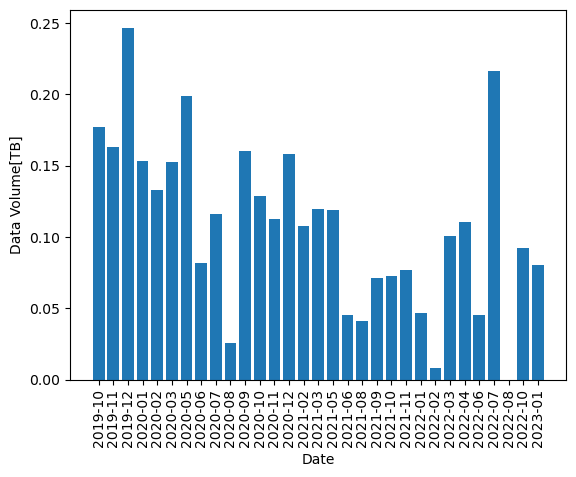

In [45]:
df_GB = df_miseq01.groupby([(df_miseq01.date1.dt.year), (df_miseq01.date1.dt.month)]).sum('Content-length')
plt.bar(df_date2['date2'], df_GB['Content-Length']/(1024*1024*1024*1024))
plt.xlabel("Date");
plt.ylabel("Data Volume[TB]");
plt.xticks(rotation=90);

For obtaining 'Accumulated Data Volume', we need to change index:

In [46]:
index_GB = list(range(len(df_GB)))
df_GB['index1'] = index_GB
df_GB1 = df_GB.set_index('index1')
df_GB1['Accumulated'] = " "

For obtaining 'Accumulated Data Volume', the first row is unchanged and the rest ones have been added by the previous row:

C:\Users\faghan\AppData\Local\Temp\ipykernel_23996\3833595416.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_GB1['Accumulated'][0] = df_GB1['Content-Length'][0]
C:\Users\faghan\AppData\Local\Temp\ipykernel_23996\3833595416.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_GB1['Accumulated'][i] = df_GB1['Content-Length'][i]+df_GB1['Accumulated'][i-1]


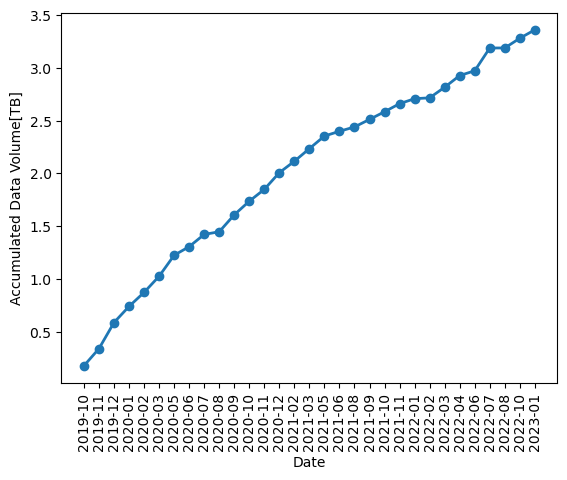

In [47]:
df_GB1['Accumulated'][0] = df_GB1['Content-Length'][0]
for i in range(1,len(df_GB1)):
    df_GB1['Accumulated'][i] = df_GB1['Content-Length'][i]+df_GB1['Accumulated'][i-1]
fig2 = plt.figure("Figure 2")
plt.plot(df_date2['date2'], df_GB1['Accumulated']/(1024*1024*1024*1024),linewidth=2, marker ='o')
plt.xticks(rotation=90);
plt.xlabel("Date");
plt.ylabel("Accumulated Data Volume[TB]");

## Predictting the "Accumulated Data Volume" for the next year. 

In [48]:
x1 = list(range(1,len(df_GB1)+1,1))

For prediction by the next year as monthly, we add 12:

In [49]:
x2 = pd.DataFrame(range(1,len(df_GB1)+12,1))

Changing byte to Tera byte (TB):

In [50]:
y = pd.DataFrame(df_GB1['Accumulated']/(1024*1024*1024*1024))

Prediction with polynomial regression by order 4:

In [51]:
model = np.poly1d(np.polyfit(x1, list(y['Accumulated']), 4))
myline = np.linspace(1, len(df_GB1)+12, 100)

To know how well the relationship between the values of the x- and y-axis is,the r-squared value is calculated:

R-squered: 0.9975353092828608


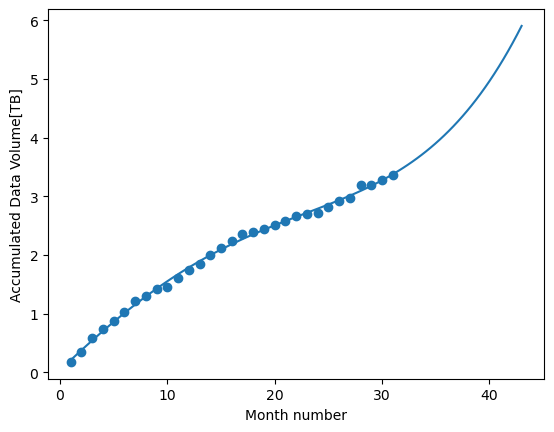

In [52]:
R2 = r2_score(list(y['Accumulated']), model(x1))
print('R-squered:',R2)
fig3 = plt.figure("Figure 3")
plt.scatter(x1, list(y['Accumulated']))
plt.plot(myline, model(myline));
plt.xlabel("Month number");
plt.ylabel("Accumulated Data Volume[TB]");

## Calculating the price of reading from the current data lake and writing to new data lake.

For read operation from the current datalake, the whole volume data have been considered (based on MB) with one operation:

In [53]:
df_GB_sum = sum(df_GB['Content-Length'])/(1024*1024)

One read Operation is applied for every 4 MB and the $0.004 is applied per 10K (Please refer to "https://azure.microsoft.com/en-us/pricing/calculator/" and set parameters for the current datalake (North Europe)).

In [54]:
cost_read = (df_GB_sum/4)*(0.004/10000)
print('cost_read: $',cost_read)

cost_read: $ 0.35234928189020154


For write operations in the new datalake, each file size is considered seperately and is added to the cost_write. Also, one write Operation is applied for every 4 MB and the $0.065 is applied per 10K (Please refer to "https://azure.microsoft.com/en-us/pricing/calculator/" and set parameters for the new datalake (Sweden Central) with File Structure: Hierarchical Namespace). 

In [55]:
cost_write = 0
for i in range(0,len(df)-1):
    cost_write = cost_write+((df['Content-Length'][i]/(1024*1024))/4)*(0.065/10000)
print('cost_write: $',cost_write)

cost_write: $ 5.725675825178727


Writing price for West Europe:

In [56]:
cost_write_w = 0
for i in range(0,len(df)-1):
    cost_write_w = cost_write_w+((df['Content-Length'][i]/(1024*1024))/4)*(0.0702/10000)
print('cost_write for West Europe: $',cost_write_w)

cost_write for West Europe: $ 6.183729891300559
